# Bike Sharing

The Shared Transport (in the pre-pandemic era XD ) is a game changer in urban mobility, this term indicates a demand-driven vehicle sharing method. Nowdays, there are many systems that allow users to rent a vehicle in a particular position and return back to another position, making urban travel easier.

Bikes, electric bikes, scooters, cars, vans ... it's possible to rent any type of vehicle just using a simple smartphone application. All these vehicles are usually connected and they have a huge number of sensors, with the data generated by the vehicles' fleet it's possible to monitor the mobility in the city!

In this example we will train a model to predict the rental count using time and environmental data. Maybe weather conditions, day of week, season, hour of the day, etc ... can affect the rental behaviors.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
# Get the data
data = pd.read_csv("./bike_data.csv")

## Quick overview

In [3]:
data.shape

(10886, 12)

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75.0,0.0,0,1,1


We have a good mix of numerical and categorical data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10015 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10451 non-null  float64
 8   windspeed   10668 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  cnt         10886 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 1020.7+ KB


There are missing values in "temp", "humidity" and "windspeed" columns

In [6]:
data.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10015.000000,10886.000000,10451.000000,10668.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.189522,23.655084,61.876663,12.803163,36.021955,155.552177,191.574132
std,0.166599,0.466159,7.795053,8.474601,19.267316,8.181219,49.960477,151.039033,181.144454
min,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,0.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,0.000000,1.000000,26.240000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
data.season.value_counts()

Winter    2734
Autumn    2733
Summer    2733
Spring    2686
Name: season, dtype: int64

In [8]:
data.weather.value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            7192
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               2834
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     859
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                    1
Name: weather, dtype: int64

We have only one example of "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog", this could be a problem but for this simple study case let's use what we have

array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'cnt'}>]], dtype=object)

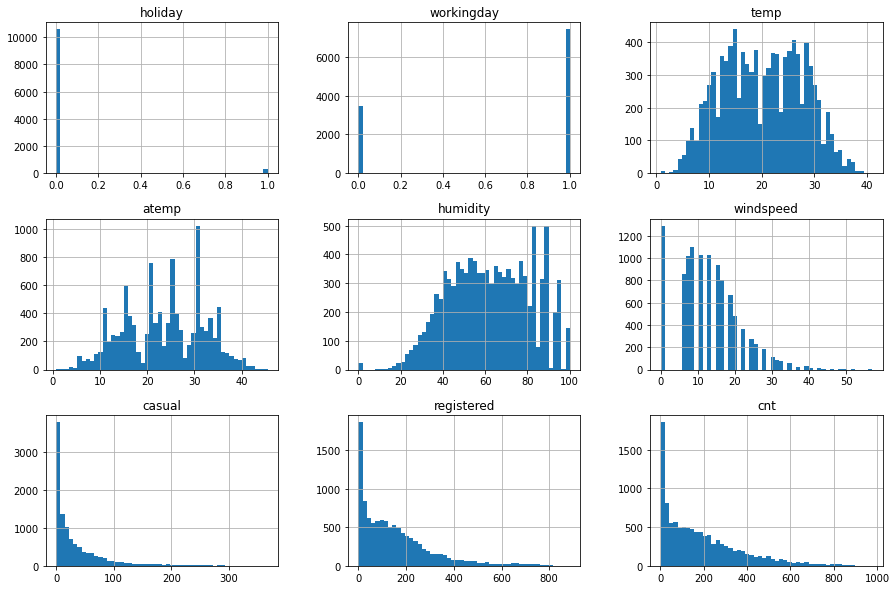

In [9]:
# A quick way to understand the available data is to plot the histogram of the numerical attributes
# The histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis).

data.hist(bins=50, figsize=(15, 10))

The histogram analysis clearly shows that the features have different scale and there are features with a very long tail. These two factors can influence the performance of the machine learning model, it is necessary to process the data as we will see later.

## Feature engineering

This phase is usually performed after analyzing the data in detail, however with a quick glance it's possible to see that we have hourly record, since the objective is to predict the rental count hour by hour it's a good idea to extract temporal values from the "timestamp" column.

In [10]:
tmp = data.datetime.astype('datetime64[ns]')

data['year'] = tmp.dt.year
data['month'] = tmp.dt.month
data['day'] = tmp.dt.day_name()
data['hour'] = tmp.dt.hour

In [11]:
# Let's check if it's a weekend day or not
data['weekend'] = ((tmp.dt.dayofweek) // 5 == 1).astype(int)

In [12]:
# Remove the datetime column no longer needed
data.drop(['datetime'], axis=1, inplace=True)

## Test Train split
Overfitting it's a problem not only related to machine learning model, our brain is affected too. We are very good at finding interesting pattern and that could influence the choice of a particular model. This is called "data snooping bias". It's a good idea to create a test set, put it aside, and never look at it.

In [13]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=50)

“First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small, so you can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set:”

Passi di: Aurélien Géron. “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow”. Apple Books. 

In [14]:
# Let's create a fresh copy of the training set
bike_data = train_set.copy()

## Data visualization

<AxesSubplot:xlabel='day', ylabel='cnt'>

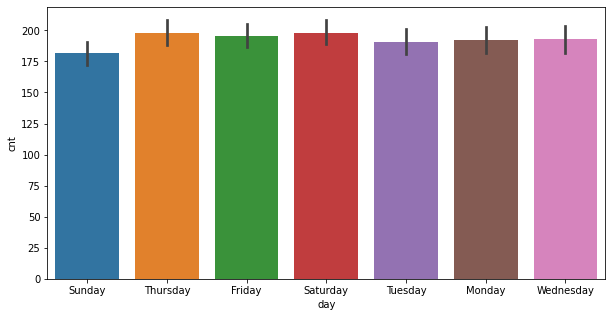

In [15]:
# let's check how the rentcount is releted to the day of the week
plt.figure(figsize=(10, 5))
sns.barplot(x="day", y="cnt", data=bike_data)

Surprisingly there are a lot of rent during the week, I would have bet the opposite.

<AxesSubplot:xlabel='month', ylabel='cnt'>

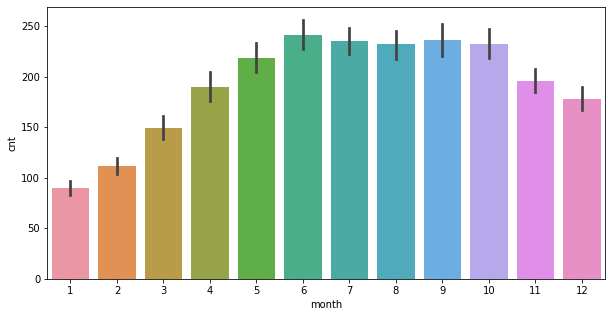

In [16]:
# How is count related to month?
plt.figure(figsize=(10, 5))
sns.barplot(x="month", y="cnt", data=bike_data)

There are few rent during cold months

<AxesSubplot:xlabel='season', ylabel='cnt'>

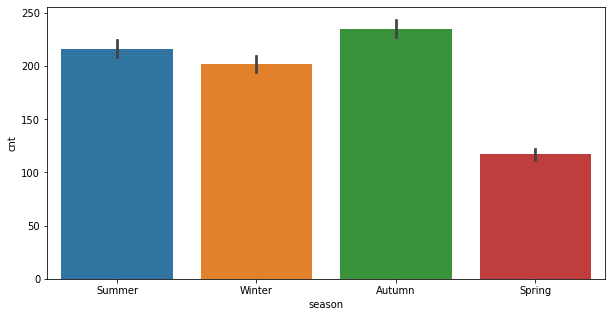

In [17]:
# Let's check the season distribution 
plt.figure(figsize=(10, 5))
sns.barplot(x="season", y="cnt", data=bike_data)

Few rents during spring? Another unexpected result

<AxesSubplot:xlabel='cnt', ylabel='weather'>

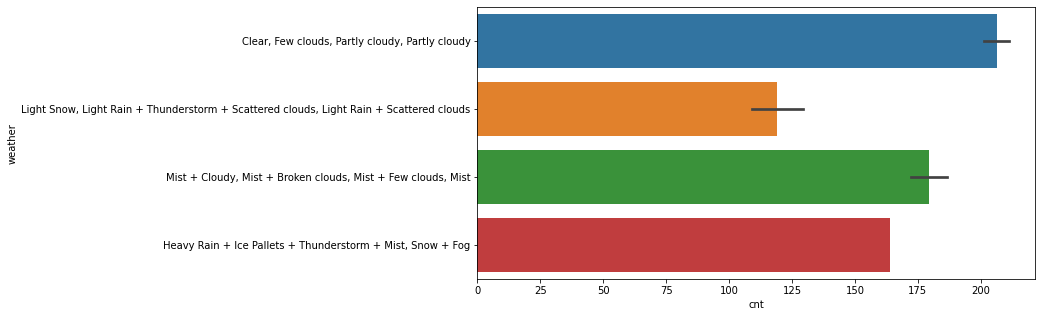

In [18]:
# Finally let's see how the weather affects rents
plt.figure(figsize=(10, 5))
sns.barplot(x="cnt", y="weather", data=bike_data, orient="h")

In [19]:
bike_data.weather.value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            5778
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                               2265
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     664
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                    1
Name: weather, dtype: int64

We have only one sample of "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog", this is a problem for a real application and we should use sampling techniques or collect more data. However, for this study let's use what we have XD 

## Check for correlation

In [20]:
# Since the dataset is not too large it's possible to compute the standard correlation coefficient between every pair of features
corr_matrix = bike_data.corr()

In [21]:
# check the correlation with the count attribute
corr_matrix.cnt.sort_values(ascending=False)

cnt           1.000000
registered    0.970327
casual        0.688394
hour          0.399576
temp          0.396196
atemp         0.388332
year          0.261998
month         0.170160
windspeed     0.105177
workingday    0.008666
holiday       0.002418
weekend      -0.009773
humidity     -0.318826
Name: cnt, dtype: float64

The number of registered users it's very correlated to the rent count, same with the casual number, this is because the total number of users is the sum of this two numbers! 
I think it's better to remove these two data, how can we know the type of users previously?  It's better to build a model only using climate and time data.

In [22]:
bike_data.drop(['registered', 'casual'], axis=1, inplace=True)

array([[<AxesSubplot:xlabel='cnt', ylabel='cnt'>,
        <AxesSubplot:xlabel='temp', ylabel='cnt'>,
        <AxesSubplot:xlabel='atemp', ylabel='cnt'>,
        <AxesSubplot:xlabel='hour', ylabel='cnt'>,
        <AxesSubplot:xlabel='month', ylabel='cnt'>,
        <AxesSubplot:xlabel='year', ylabel='cnt'>,
        <AxesSubplot:xlabel='windspeed', ylabel='cnt'>,
        <AxesSubplot:xlabel='humidity', ylabel='cnt'>],
       [<AxesSubplot:xlabel='cnt', ylabel='temp'>,
        <AxesSubplot:xlabel='temp', ylabel='temp'>,
        <AxesSubplot:xlabel='atemp', ylabel='temp'>,
        <AxesSubplot:xlabel='hour', ylabel='temp'>,
        <AxesSubplot:xlabel='month', ylabel='temp'>,
        <AxesSubplot:xlabel='year', ylabel='temp'>,
        <AxesSubplot:xlabel='windspeed', ylabel='temp'>,
        <AxesSubplot:xlabel='humidity', ylabel='temp'>],
       [<AxesSubplot:xlabel='cnt', ylabel='atemp'>,
        <AxesSubplot:xlabel='temp', ylabel='atemp'>,
        <AxesSubplot:xlabel='atemp', ylabel='atem

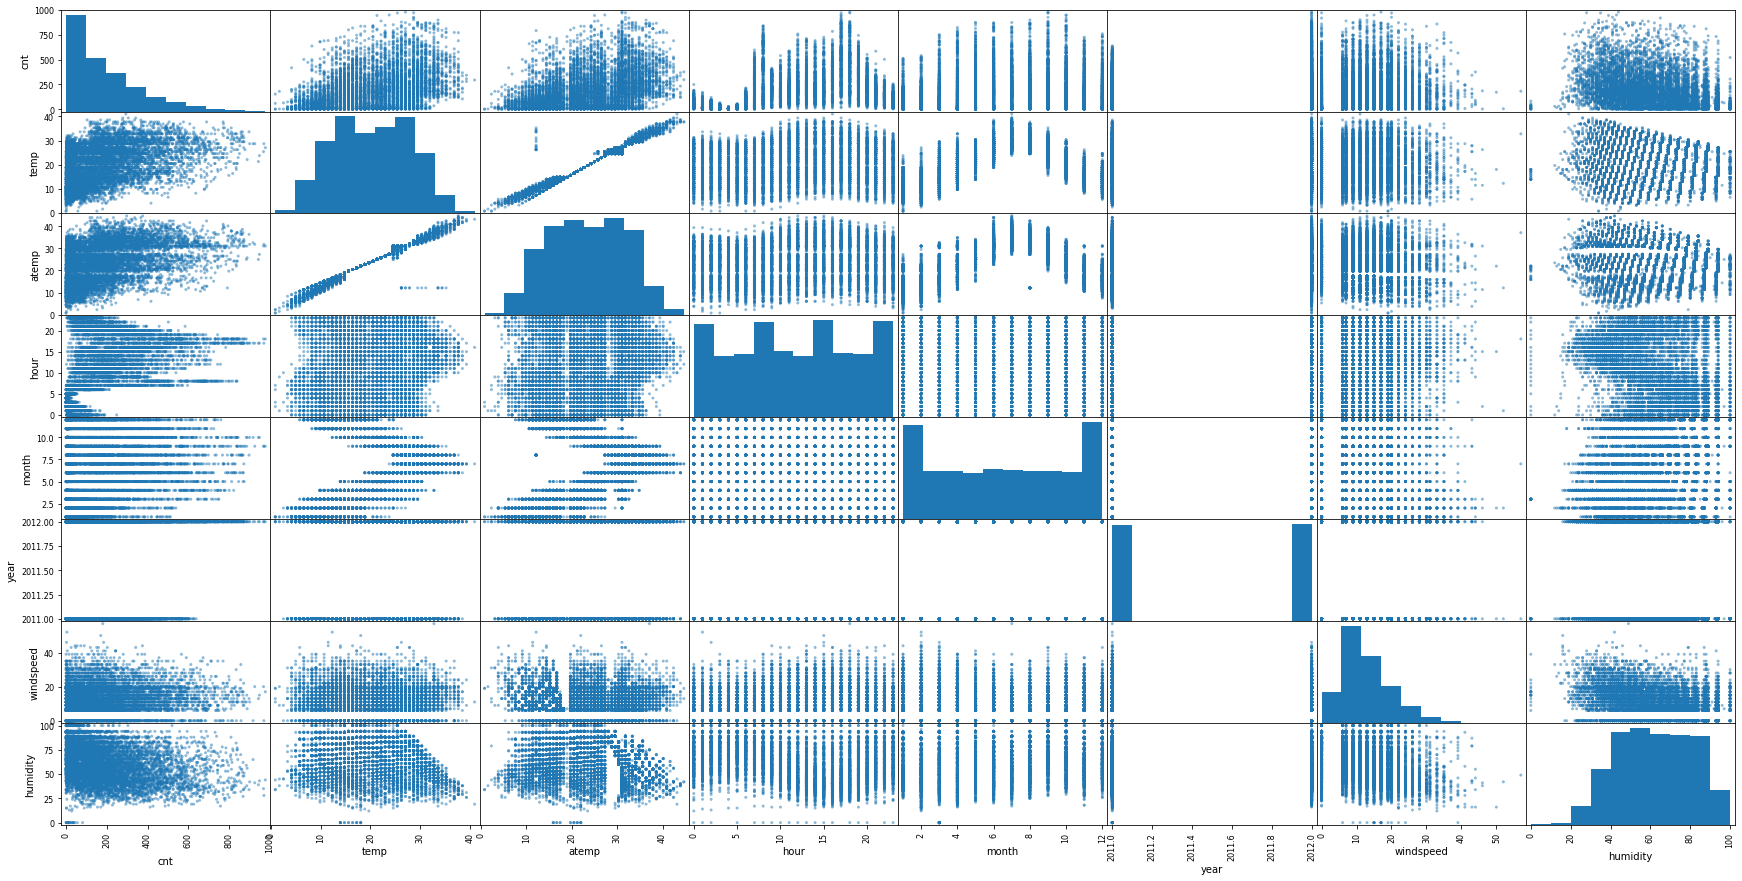

In [23]:
# let's plot the correlation with few promising attributes using the scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["cnt", "temp", "atemp", 'hour', 'month', 'year', 'windspeed', 'humidity']

scatter_matrix(bike_data[attributes], figsize=(30, 15))

"temperature", "atemp", "hour" and "month" are correlated to rental count, it's interesting to note that "humidity" and rental count are negatively correlated. 

In [24]:
# prepare data for machine learning algorithm
bike_data = train_set.drop(['cnt', 'casual', 'registered'], axis=1) # drop labels for training set
bike_labels = train_set.cnt.copy()

## Data cleaning

In [25]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8708 entries, 7763 to 5600
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8708 non-null   object 
 1   holiday     8708 non-null   int64  
 2   workingday  8708 non-null   int64  
 3   weather     8708 non-null   object 
 4   temp        8022 non-null   float64
 5   atemp       8708 non-null   float64
 6   humidity    8344 non-null   float64
 7   windspeed   8530 non-null   float64
 8   year        8708 non-null   int64  
 9   month       8708 non-null   int64  
 10  day         8708 non-null   object 
 11  hour        8708 non-null   int64  
 12  weekend     8708 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 952.4+ KB


We have three options to deal with null value:
1. Drop the corresponding row
2. Drop the column
3. Use a value to replace the missing one 

We will use the SimpleImputer() class of sklearn to replace null values with the median of the corresponding column

In [26]:
# Let's get the numerical columns
bike_num = bike_data.drop(['season', 'weather', 'day'], axis=1)

In [27]:
# This is an example of usage, we will use it into a pipeline
imputer = SimpleImputer(strategy='median')
imputer.fit(bike_num)

SimpleImputer(strategy='median')

In [28]:
# the statistics variable contains the median for each numerical column
imputer.statistics_

array([0.0000e+00, 1.0000e+00, 2.0500e+01, 2.4240e+01, 6.1500e+01,
       1.2998e+01, 2.0120e+03, 7.0000e+00, 1.2000e+01, 0.0000e+00])

In [29]:
# The result it's a numpy array
imputer.transform(bike_num)

array([[ 0.  ,  0.  , 27.06, ...,  6.  , 20.  ,  1.  ],
       [ 0.  ,  0.  , 18.04, ..., 12.  , 15.  ,  1.  ],
       [ 0.  ,  1.  , 22.96, ..., 10.  , 10.  ,  0.  ],
       ...,
       [ 0.  ,  1.  , 13.12, ...,  2.  , 19.  ,  0.  ],
       [ 0.  ,  1.  , 11.48, ..., 11.  ,  4.  ,  0.  ],
       [ 0.  ,  0.  , 14.76, ...,  1.  , 11.  ,  1.  ]])

## Categorycal data
Machine Learning models work better with numerical data.
There are a lot of methods that allow to convert text in numbers but one of the best is "One Hot Encoding"

In [30]:
# We need categorical features
bike_cat = bike_data[['season', 'weather', 'day']]

In [31]:
# This is an example of usage
cat_encoder = OneHotEncoder()
bike_1_hot = cat_encoder.fit_transform(bike_cat)

In [33]:
bike_1_hot

<8708x15 sparse matrix of type '<class 'numpy.float64'>'
	with 26124 stored elements in Compressed Sparse Row format>

## Feature Scaling


Machine Learning algorithms don’t perform well when the input features have very different scales. It's a good idea to transform numerical values to an homogenous range, there are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Standardization is more outlier resistant, for this reason we will use the StandardScaler() class of sklearn

## Pipelines
During the development of a Machine Learning model, there are a lot of steps to execute in the right order. Fortunately we have the Pipeline class of sklearn to help with the sequence of transformations. 


In [34]:
# Let's create a pipeline to elaborate numerical columns
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

bike_num_tr = num_pipeline.fit_transform(bike_num)
bike_num_tr

array([[-0.16942974, -1.46801651,  0.90555207, ..., -0.15080514,
         1.21867199,  1.56833485],
       [-0.16942974, -1.46801651, -0.29521514, ...,  1.59278131,
         0.49504083,  1.56833485],
       [-0.16942974,  0.68119125,  0.35974879, ...,  1.01158582,
        -0.22859033, -0.63761894],
       ...,
       [-0.16942974,  0.68119125, -0.95017908, ..., -1.31319611,
         1.07394576, -0.63761894],
       [-0.16942974,  0.68119125, -1.16850039, ...,  1.30218357,
        -1.09694772, -0.63761894],
       [-0.16942974, -1.46801651, -0.73185776, ..., -1.60379386,
        -0.0838641 ,  1.56833485]])

In [36]:
# ColumTransformer allows to handle categorical and numerical data simultaneously 

num_attribs = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'weekend']
cat_attribs = ['season', 'weather', 'day']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

## Train a Machine Learning Model

In [37]:
# Prepare the data using our pipeline
bike_tr = full_pipeline.fit_transform(bike_data)
bike_tr

array([[-0.16942974, -1.46801651,  0.90555207, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16942974, -1.46801651, -0.29521514, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16942974,  0.68119125,  0.35974879, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.16942974,  0.68119125, -0.95017908, ...,  1.        ,
         0.        ,  0.        ],
       [-0.16942974,  0.68119125, -1.16850039, ...,  0.        ,
         0.        ,  1.        ],
       [-0.16942974, -1.46801651, -0.73185776, ...,  0.        ,
         0.        ,  0.        ]])

The first model we will train it's a simple linear regression model

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(bike_tr, bike_labels)

LinearRegression()

In [39]:
# Let's use a very stupid approach to measure model's performance

some_data = bike_data.iloc[:5]
some_labels = bike_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels)) 

Predictions: [398.484375  278.390625   86.0234375 297.984375  140.265625 ]
Labels: [314, 417, 69, 382, 93]


Not so bad XD it's the first try after all!

## Cross Validation
A better approach to evaluate a model it's cross-validation. With this method, we train our model on different subsets of the data to get multiple measures of model quality.

In [40]:
# Train another linear regression model using cross-validation using 10 subset
lin_model = LinearRegression()
lin_scores = cross_val_score(lin_model, bike_tr, bike_labels, scoring="neg_mean_squared_error", cv=10)
np.sqrt(-lin_scores)

array([1.39227045e+02, 1.37662152e+02, 1.43802753e+02, 1.45194988e+02,
       1.47931202e+02, 1.38453839e+02, 1.33033455e+02, 2.17908539e+12,
       1.41514658e+02, 1.42902254e+02])

Very poor performances, let's try a powerful model

In [41]:
# Now we will train a slightly powerful model: a decision tree
tree_model = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_model, bike_tr, bike_labels, scoring="neg_mean_squared_error", cv=10)
np.sqrt(-tree_scores)

array([55.98683624, 59.64393968, 60.34170779, 55.24589901, 64.70821198,
       60.5000593 , 58.28992426, 64.75347581, 60.94721666, 63.31570233])

Much better! But I think that we can improve the performances using a famous ensamble method :)

In [42]:
# Let's try a random forest regression model
forest_model = RandomForestRegressor()

forest_score = cross_val_score(forest_model, bike_tr, bike_labels, scoring="neg_mean_squared_error", cv=10)

np.sqrt(-forest_score)


array([41.23672681, 40.01463149, 41.4646164 , 42.57591962, 44.66136609,
       41.12230602, 38.71188026, 42.83826017, 41.28951523, 46.92290743])

Not bad, not bad at all! But there is room for improvement.

## Fine Tuning
So far we used the default hyperparameters for our models. However, there are some changes that we can do to achieve better performances. We could tweak hp manually, but we are engineers and we are lazy.
Instead we can use the GridSearchCV class to automatically find the best hyperparameters combination.

In [43]:
# We need to specify the hp to experiment, GridSearchCV uses cross-validation
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

model = RandomForestRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [44]:
grid_search.fit(bike_tr, bike_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
# What's the best combination?
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [46]:
# and the best estimator is
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [47]:
# We can check the score of all the combinations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

121.1699174525038 {'max_features': 2, 'n_estimators': 3}
97.92170945911782 {'max_features': 2, 'n_estimators': 10}
95.50316676812521 {'max_features': 2, 'n_estimators': 30}
103.25284422427343 {'max_features': 4, 'n_estimators': 3}
86.05555648428998 {'max_features': 4, 'n_estimators': 10}
80.75333825098885 {'max_features': 4, 'n_estimators': 30}
88.03823666677418 {'max_features': 6, 'n_estimators': 3}
75.64020995727772 {'max_features': 6, 'n_estimators': 10}
69.12852197449325 {'max_features': 6, 'n_estimators': 30}
80.84271977307958 {'max_features': 8, 'n_estimators': 3}
64.63467764096347 {'max_features': 8, 'n_estimators': 10}
57.52845997489497 {'max_features': 8, 'n_estimators': 30}
114.18415822641668 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
98.49859925468837 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
106.07339856353437 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
90.71184149198703 {'bootstrap': False, 'max_features': 3, 'n_estimators':

Another great thing of this approach is that by inspecting the best model we can gain insight about the most important features

In [48]:
importances = grid_search.best_estimator_.feature_importances_

In [49]:
importances

array([2.23948701e-03, 2.19784521e-02, 7.11782969e-02, 1.07442340e-01,
       7.84161499e-02, 3.18655742e-02, 7.23064987e-02, 3.72694540e-02,
       4.75088002e-01, 1.74460463e-02, 3.79480535e-03, 1.38609249e-02,
       4.65389645e-03, 6.13074906e-03, 5.86122901e-03, 2.88315057e-06,
       1.00458958e-02, 5.28402982e-03, 4.93159902e-03, 3.97465193e-03,
       6.36603529e-03, 6.10264486e-03, 3.93679502e-03, 4.41374001e-03,
       5.40981918e-03])

In [50]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs  + cat_one_hot_attribs

sorted(zip(importances, attributes), reverse=True) 

[(0.4750880023166397, 'hour'),
 (0.10744233974375499, 'atemp'),
 (0.07841614986971253, 'humidity'),
 (0.07230649871210484, 'year'),
 (0.07117829694330904, 'temp'),
 (0.03726945397635721, 'month'),
 (0.03186557417782709, 'windspeed'),
 (0.021978452080305657, 'workingday'),
 (0.017446046263327387, 'weekend'),
 (0.013860924937119275, 'Spring'),
 (0.006130749056886865, 'Winter'),
 (0.004653896446219424, 'Summer'),
 (0.0037948053498588143, 'Autumn'),
 (0.002239487005577775, 'holiday')]

## Evaluating on Test Set
It's time to evaluate our model on the test set. Let's see the result of our hard work:

In [51]:
final_model = grid_search.best_estimator_

x_test = test_set.drop(['cnt', 'casual', 'registered'], axis=1)
y_test = test_set.cnt

x_test_tr = full_pipeline.transform(x_test)

pred = final_model.predict(x_test_tr)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

In [52]:
rmse

58.42847024069036

The result it's promising, maybe we can improve this result simply using more data. We use only weather and temporal data! other data scientists worked on this dataset obtaining better results but they included the number of registered and casual users. As we have seen, this is stupid because if we have these number we can find the number of rentals with a simple addiction XD   

In [53]:
# The last thing we can do is to compute the 95% confidence interval to have an idea of how precise this estimate is
confidence = 0.95

squared_errors = (pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([55.15482754, 61.52818272])

We could try other parameters, more powerful models and maybe use regularization but for this study case it whould be too much. The goal w